In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-12-11 17:46:04.037543: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 17:46:04.129054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733926564.170106  198573 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733926564.181996  198573 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 17:46:04.270330: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def load_and_preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (612, 612))
    image = image.astype(np.float32)
    image = (image / 127.5) - 1
    return image


In [3]:
def orient_image(preprocessed_image, predictions):
    class_name = model_label2name[np.argmax(predictions)]
    oriented_image = get_oriented_image(preprocessed_image, orient2degree[class_name])
        
    return oriented_image ,class_name


In [23]:
import math
def affine_image(image ,degree) :
    
    height, width = image.shape[:2]
    heightNew = int(width * abs(math.sin(math.radians(degree))) + height * abs(math.cos(math.radians(degree))))
    widthNew = int(height * abs(math.sin(math.radians(degree))) + width * abs(math.cos(math.radians(degree))))

    M = cv2.getRotationMatrix2D((width/2, height/2), degree, 1)
    M[0, 2] += (widthNew - width) / 2
    M[1, 2] += (heightNew - height) / 2
    res = cv2.warpAffine(image, M, (widthNew, heightNew), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return res



In [4]:
def get_oriented_image(image, orientation_degree):
    if orientation_degree == 90:
        # Rotate each channel separately
        image = [cv2.flip(channel.T, 0) for channel in cv2.split(image)]
        image = cv2.merge(image)
    elif orientation_degree == 180:
        image = cv2.flip(image, -1)
    elif orientation_degree == 270:
        image = [cv2.flip(channel.T, 1) for channel in cv2.split(image)]
        image = cv2.merge(image)

    return image


In [5]:
model_label2name = {0:'down2up', 1:'up2down' ,2:'right2left',3:'left2right'}
orient2degree = {'right2left': 270, 'left2right': 90, 'up2down': 180, 'down2up': 0}


In [6]:
image_path = "./input_1.jpeg"
image = cv2.imread(image_path)
preprocessed_image = load_and_preprocess_image(image)
input_tensor = tf.expand_dims(preprocessed_image, axis=0)


I0000 00:00:1733926566.873729  198573 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9393 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


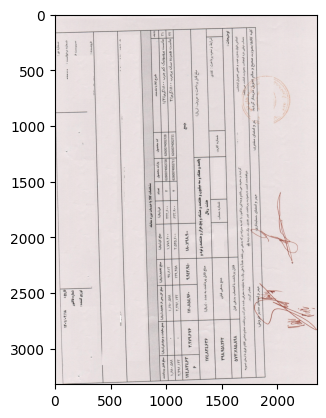

In [7]:
plt.imshow(image)

## Orient Detection

In [8]:
import tensorflow as tf

saved_model = tf.saved_model.load('./saved_model')
infer = saved_model.signatures['serving_default']


In [9]:
with tf.device('/CPU:0'):
    predictions = infer(tf.constant(input_tensor))

output = predictions['dense']
print(output)


tf.Tensor([[0.01965518 0.05360978 0.838517   0.08821807]], shape=(1, 4), dtype=float32)


In [10]:
oriented_image ,class_name = orient_image(image, output)


In [11]:
class_name

'right2left'

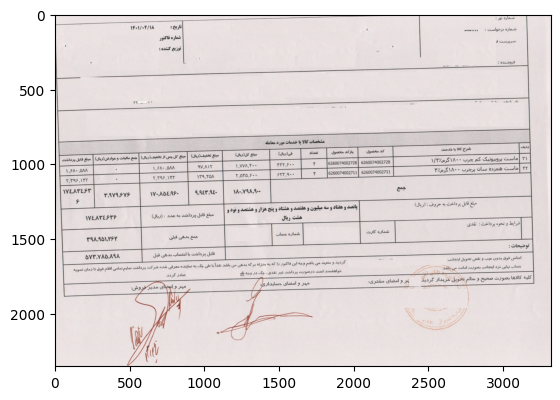

In [12]:
plt.imshow(oriented_image)

## Method 1 - Furier Transform

In [13]:
class SkewFurier() :

    def preprocess(self, image):
        h, w, c = image.shape
        x_center, y_center = (w // 2, h // 2)

        # Find angle to rotate image
        rotation_angle = self.get_skewed_angle(image)
        print(f"[INFO]: Rotation angle is {rotation_angle}")

        M = cv2.getRotationMatrix2D((x_center, y_center), rotation_angle, 1.0)
        borderValue = (255, 255, 255)

        rotated_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderValue=borderValue)
        return rotated_image

    def get_skewed_angle(self, image, angle_max = None, search_ratio = 5):
        """Getting angle from a given document image.

        image : np.ndarray
        vertical_image_shape : int
        resize image as preprocessing
        angle_max : float
        maximum angle to searching
        """
        assert isinstance(image, np.ndarray), image


        if angle_max is None:
            angle_max = 5

        m = self._get_fft_magnitude(image)
        a = self._get_angle_radial_projection(m, angle_max=angle_max, num = search_ratio)
        return a

    def _ensure_gray(self, image):
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        except cv2.error:
            pass
        return image


    def _ensure_optimal_square(self, image):
        assert image is not None, image
        nw = nh = cv2.getOptimalDFTSize(max(image.shape[:2]))
        output_image = cv2.copyMakeBorder(
            src=image,
            top=0,
            bottom=nh - image.shape[0],
            left=0,
            right=nw - image.shape[1],
            borderType=cv2.BORDER_CONSTANT,
            value=255,
        )
        return output_image

    def _ensure_gray(self, image):
        if len(image.shape) == 3:
            return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return image

    def _get_fft_magnitude(self, image):
        gray = self._ensure_gray(image)
        opt_gray = self._ensure_optimal_square(gray)

        opt_gray = cv2.adaptiveThreshold(
            ~opt_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -10
        )

        dft = np.fft.fft2(opt_gray)
        shifted_dft = np.fft.fftshift(dft)
        magnitude = np.abs(shifted_dft)
        return magnitude

    def _get_angle_radial_projection(self,m, angle_max=None, num=None):
        """Get angle via radial projection.

        Arguments:
        ------------
        angle_max : float
        num : int
        number of angles to generate between 1 degree
        """
        assert m.shape[0] == m.shape[1]
        r = c = m.shape[0] // 2

        if angle_max is None:
            pass

        if num is None:
            num = int((angle_max - (-angle_max)) / 0.5 + 1)

        tr = np.linspace(-1 * angle_max, angle_max, int(angle_max * num * 2)) / 180 * np.pi
        profile_arr = tr.copy()

        def f(t):
            _f = np.vectorize(
                lambda x: m[c + int(x * np.cos(t)), c + int(-1 * x * np.sin(t))]
            )
            _l = _f(range(0, r))
            val_init = np.sum(_l)
            return val_init

        vf = np.vectorize(f)
        li = vf(profile_arr)

        a = tr[np.argmax(li)] / np.pi * 180

        if a == -1 * angle_max:
            return 0
        return a


In [14]:
skew_corrector = SkewFurier()
img = cv2.cvtColor(oriented_image, cv2.COLOR_BGR2RGB)
furier_oriented_image = skew_corrector.preprocess(img)


[INFO]: Rotation angle is -1.5306122448979593


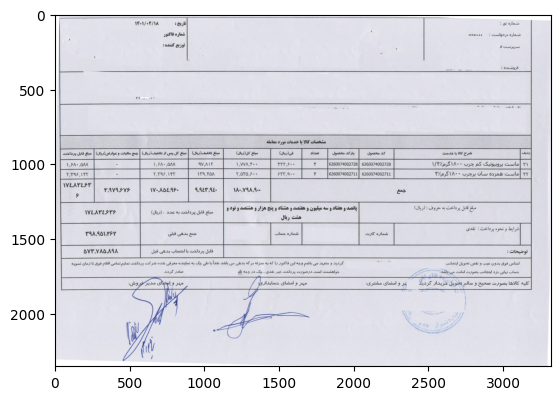

In [15]:
plt.imshow(furier_oriented_image)

## Tesseract

In [64]:
pip install pytesseract pillow


Note: you may need to restart the kernel to use updated packages.


In [16]:
import pytesseract

x = pytesseract.image_to_string(furier_oriented_image,lang='fas')
print(x)

شماره تور : تاریخ : ۱۳۰۱/۰۴/۱۸

شماره درخواست ‎ :‏ ۸۸۰ مد 1 شماره فاکتور
۰
سرپرست ف توزیع کننده :
فروشنده : 1 اش
ااسی ۲۲5
مشخصات کالا با خدمات مورد معامله

 

ردیف

»

۳ اماست همزده سان پرچرب ۱۸۰۰گرم:۴ 1 ]6260074002711

 

| تعداد | فی(ریال) مبلغ کل(ریال) مبلغ تخفیف(ریال) | مبلغ کل پس از تخقیف(ریال) | جمع مالیات و عوارض(ریال)
۳ ۱۰ ۹/۳ ۱۸۸ ۱/۸۸
مومع ۳۶ ۱۳۹,۵۸ ۳۳۳ ۲ ۳

و ۱۵
۰ ۰( ۶ ۳ ۶
کا م۱۵
۳۹

گردید و متعهد می باشم وجه این فاکتور را که به منزله برگه بدهی می باشد نقداً یا طی چک به نماینده معرفی شده شر کت پرداخت نمایم.تمامی اقلام فوق تا زمان تسویه

     
 
    

مبلغ قابل پرداخت به عدد : (ریال)

 

    

 

اجناس فوق بدون عیب و نقص تحویل اینجانب

 
  

حساب نهایی نزد اینجانب بصورت امانت می‌جاشت: : یر خواهشمند است درصورت پرداخت غیر نقدی » چک در وجه ش صادر گردد.

رو سوم ول خر کر راما سفتری یروس سار رو

 



In [17]:
import pytesseract

z = pytesseract.image_to_string(oriented_image,lang='fas')
print(z)

شماره تور : تاریخ :+ ۱۳۱۴/۸

شماره درخواست : هل شماره فاکتور

۰
سرپرست وف ی توزیع کننده :
فروشنده : 2

  

مشخصات کالا با خدمات مورد معامله

سک با رها که رس | وت موه اس یی ییا مومس شک
ماست پروبیوتیک کم چرب ۱۸۰۰گرم:۱/۴ 8 ]62600074002728 جع ۱۴۰ ۲ ۸۸ ۱
ماست همزده سان پرچرب ۱۸۰۰ گرم/:۴ 41 ]6260074002711 +۳۳ ۳۰ ۱۳۹,۳۹۸ نا ۳۱۲

۱۳
۶ ۳۶ 12

م۱

   

     
   

    
 

 
         

     
 
    
   

         
 

    

   

 

۱۳۰ ی(

 
   

پانصد و هفتاد و سه میلیون و هفتصد و هشتاد و پنج هزار و هشتصد و نود و
هشت ریال

   

مبلغ قابل پرداخت به عدد : (ریال)

  
   
 
 
 
 
 
 

      
  

ری ی مدروه بر هامرهم حام ری ری یات مرن و خر ماه رات برش کم و ور

حساب نهایی نزد اینجانب بصورت امانت می«باشد: مس رصن خواهشمند ات خارصورت پرداخت غیر نقی :چگ در وجه شا صادر گردد.

کی سوت سح وم ول رها او رای ری س ک ص ۳

اجناس فوق بدون عیب و نقص تحویل اینجانب

  
  

 

     

 

 



## Method 2 for Skew

In [20]:
blank = np.zeros((oriented_image.shape[0], oriented_image.shape[1]), dtype=np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
# Binarization
gray_image = cv2.cvtColor(oriented_image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
erosion = cv2.erode(opening, kernel)
edges = cv2.Canny(erosion, 80, 240, apertureSize=3)
# Hough line transform
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 200, minLineLength=250, maxLineGap=70)
lines1 = lines[:, 0, :]
Theta = np.arctan2(lines1[:, 1] - lines1[:, 3], lines1[:, 2] - lines1[:, 0]) * 180/np.pi
# Filter vertical lines 
valid_indices = np.where((Theta >= -35) & (Theta <= 35))
Theta = Theta[valid_indices]
lines1 = lines1[valid_indices]
# Rotate
angle_i, angle = np.histogram(Theta, bins=90)
angle_m = angle_i.argmax()
degree = -angle[angle_m]


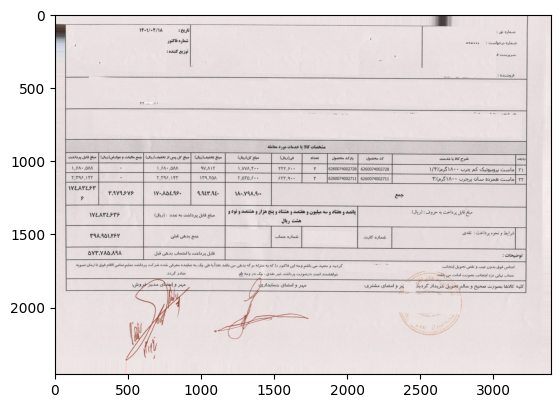

In [24]:
rotated_image = affine_image(oriented_image ,degree)
plt.imshow(rotated_image)

In [45]:
m2 = pytesseract.image_to_string(rotated_image,lang='fas')
print(m2)

شماره تور : تاریخ :+ ۱۳۰۱/۰۴/۱۸
شماره درخواست : ۸۸۰ مد ۲ شماره فاکتور
۰
۳ توزیع کننده :
فروشنده : 1 اش
۲ .:
مشخصات کالا با خدمات مورد معامله

 

بارکد محصول

   
 
  

فی(ریال) مبلغ کل(ریال) مبلغ تخفیف(ریال) | مبلغ کل پس از تخقیف(ریال) | جمع مالیات و عوارض(ریال) | مبلغ قابل پرداخت
۳ ۱ ۹/۲ ۱/۸۸ ی ۱/۸۸
۳۳۰ ۳۰ ۱۳۹۴۵۸ ۳۳۹۲ ۳ ۳۳۲

او ۱۵
۹/۹5 ۱۰( ۳۹۶
۱۳۶

۳

5 گردید و متعهد می باشم وجه این فاکتور را که به منزله برگه بدهی می باشد نقداً یا طی چک به نماینده معرفی شده شرکت پرداخت نمایم.تمامی اقلام فوق تا زمان تسویه
حساب نهایی نزد اینجانب بصورت امانت می«چاشد: 2 و 9 خواهشمند است درصورت پرداخت غیر نقدی . چک در وجه شٍ صادر گردد.

سوت دس وسام یرورابان موی وس سر رسک

7

۳

ماست پروبیوتیک کم چرب ۱۸۰۰گرم:۱/۴ 28ید
03

   

28 یریش

6001

     
 
  

  

ماست همزده سان پرچرب ۱۸۰۰گرم:۴

 

     

۱۳۰

     
   
 

  

پانصد و هفتاد و سه میلیون و هفتصد و هشتاد و پنج هزار و هشتصد و نود و

   

اقا اخت ف : (ریا
مبلغ قابل پرداخت به حروف : (ریال) مبلغ قابل پرداخت به عدد : (ریال)

  

اجناس فوق بدون عیب و نقص تح

## Method 3 for deskew

In [28]:
gray_image = cv2.cvtColor(oriented_image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray_image, (5, 5), 0)
org_height , org_width= gray_image.shape[:2]
height,width = gray_image.shape[:2]
org_center = (width//2, height//2)
center = (width//2, height//2)
# threshold image
_, threshed = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# dilate image
dilate = cv2.dilate(threshed, (35, 35), iterations=3)
lines = cv2.HoughLinesP(dilate,1,np.pi/180,200,None,150,10)
rotation_angle = None
if lines is not None:
    lines_array = np.squeeze(np.array(lines))
    diff_x = lines_array[:, 2] - lines_array[:, 0]
    diff_y = lines_array[:, 3] - lines_array[:, 1]

    slopes = diff_y / (diff_x + 1e-10)
    angles = np.degrees(np.arctan(slopes))

    # Filter based on angles (horizontal filter)

    horizontal_mask = np.abs(angles) < 30

    # Extract horizontal lines based on angle threshold

    horizontal_lines = lines_array[horizontal_mask]
    filtered_angles = angles[horizontal_mask]

    Q1, Q3 = np.percentile(filtered_angles, [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    non_outliers_mask = (filtered_angles >= lower_bound) & (filtered_angles <= upper_bound)

    filtered_angles = filtered_angles[non_outliers_mask]
    final_horizontal_lines = horizontal_lines[non_outliers_mask]

    if len(filtered_angles) != 0:
        rotation_angle = sum(filtered_angles) / len(filtered_angles)

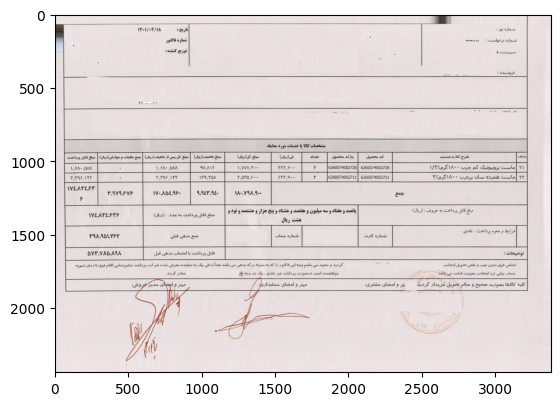

In [29]:
rotated_image_method3 = affine_image(oriented_image ,rotation_angle)
plt.imshow(rotated_image_method3)

In [44]:
m3 = pytesseract.image_to_string(rotated_image_method3,lang='fas')
print(m3)

ی تاریخ : ۱۳۳/۸

شماره درخواست : ۸۸۰ دم ی شماره فاکتور
۰
سرپرست ف ی توزیع کننده :
فروشنده : 1 اش
مشخصات کالا با خدمات مورد معامله

 

مبلغ قابل پرداخت

تاکسا سس سس سس سس
ماست پروبیوتیک کم چرب ۱۸۰۰گرم/:۱/۴ 8 ]6260074002728 ۳ ۱۴۰ ۹/۲ ۱/۸۸
ماست همزده سان پرچرب ۱۸۰۰ گرم:۴ 1 ]6260074002711 ۳۳۰ ۳۰ ۱۳۹,۴۵۸ ۳۳۹۲ ۳۳۲

۱۳
۹۹ ی( ۳۶

۱ ۸۸

 

   
 
  

۱۳۰

 

    

    

پانصد و هفتاد و سه میلیون و هفتصد و هشتاد و پنج هزار و هشتصد و نود و
هشت ریال

اجناس فوق بدون عیب و نقص تحویل اینجانتنب گردید و متعهد می باشم وجه این فاکتور را که به منزله برگه بدهی می باشد نقداً یا طی چک به نماینده معرفی شده شر کت پرداخت نمایم.تمامی اقلام فوق تا زمان تسویه

حساب نهایی نزد اینجانب بصورت امانت می«چاشت: سر خواهشمند است درصورت پرداخت غیر نقدی . چک در وجه ش صادر گردد.

وت ی وعام ول شرا و رای موی اس

/ /

   
  
 

مبلغ قابل پرداخت به حروف : (ریال)

     
 

   



## Method 4 --> perfectly accurate but slow ( good for data labeling ) 

In [39]:
from scipy.ndimage import rotate

def determine_score(arr, angle):
    # order of 0 indicates that nearest-neighbor interpolation should be used
    data = rotate(arr, angle, reshape=False, order=0)  # ensures that the array's shape remains unchanged (reshape=False).
    histogram = np.sum(data, axis=1, dtype=float) # do sum for each row because of axis = 1
    score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
    return histogram, score

def determine_score_wrapper(args):
    return determine_score(*args)


In [40]:
from multiprocessing import Pool


gray_image = cv2.cvtColor(oriented_image, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) 

limit = 20
step = 0.2

angles = np.arange(-limit, limit + step, step)
with Pool() as pool: # using pool to optimize inf time
    scores = pool.map(determine_score_wrapper, [(thresh, angle) for angle in angles])

histograms, actual_scores = zip(*scores)

best_index = np.argmax(actual_scores)
best_angle = angles[best_index]



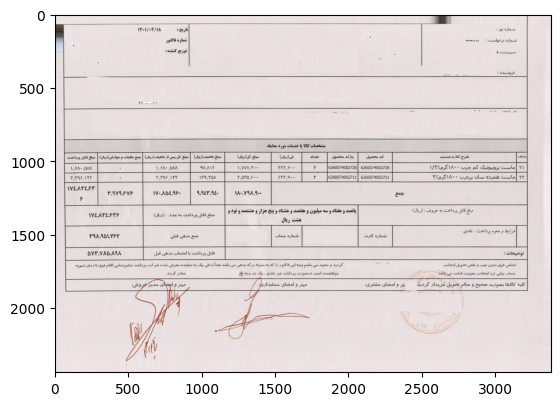

In [41]:
rotated_image_method4 = affine_image(oriented_image ,rotation_angle)
plt.imshow(rotated_image_method4)

In [43]:
m4 = pytesseract.image_to_string(rotated_image_method4,lang='fas')
print(m4)

ی تاریخ : ۱۳۳/۸

شماره درخواست : ۸۸۰ دم ی شماره فاکتور
۰
سرپرست ف ی توزیع کننده :
فروشنده : 1 اش
مشخصات کالا با خدمات مورد معامله

 

مبلغ قابل پرداخت

تاکسا سس سس سس سس
ماست پروبیوتیک کم چرب ۱۸۰۰گرم/:۱/۴ 8 ]6260074002728 ۳ ۱۴۰ ۹/۲ ۱/۸۸
ماست همزده سان پرچرب ۱۸۰۰ گرم:۴ 1 ]6260074002711 ۳۳۰ ۳۰ ۱۳۹,۴۵۸ ۳۳۹۲ ۳۳۲

۱۳
۹۹ ی( ۳۶

۱ ۸۸

 

   
 
  

۱۳۰

 

    

    

پانصد و هفتاد و سه میلیون و هفتصد و هشتاد و پنج هزار و هشتصد و نود و
هشت ریال

اجناس فوق بدون عیب و نقص تحویل اینجانتنب گردید و متعهد می باشم وجه این فاکتور را که به منزله برگه بدهی می باشد نقداً یا طی چک به نماینده معرفی شده شر کت پرداخت نمایم.تمامی اقلام فوق تا زمان تسویه

حساب نهایی نزد اینجانب بصورت امانت می«چاشت: سر خواهشمند است درصورت پرداخت غیر نقدی . چک در وجه ش صادر گردد.

وت ی وعام ول شرا و رای موی اس

/ /

   
  
 

مبلغ قابل پرداخت به حروف : (ریال)

     
 

   

